## Thiết kế CSDL Quản lý bán hàng tại một cửa hàng thực phẩm.  

### a. Hãy vẽ sơ đồ ERD (Entity Relationship Diagram) cho hệ thống này và xác định các ràng buộc (ví dụ: khóa chính, khóa ngoại, NOT NULL,…) cho các bảng một cách hợp lý. 

### b. Tạo danh sách các bản ghi để chèn dữ liệu vào từng bảng trên (lưu ý: không tạo số lượng bản ghi quá ít, tối thiểu mỗi bảng 15 bản ghi). Tận dụng những trường có thể sử dụng giá trị ngẫu nhiên để tránh chèn dữ liệu thủ công. 

In [19]:
import pandas as pd
import sqlite3
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter

In [20]:
# Kết nối tới SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Tạo bảng customers
cursor.execute('''
CREATE TABLE IF NOT EXISTS customers (
    customer_id TEXT PRIMARY KEY,
    gender TEXT CHECK(gender IN ('M', 'F')) NOT NULL,
    birth_date TEXT NOT NULL,
    signup_date TEXT NOT NULL
)
''')

# Tạo bảng products
cursor.execute('''
CREATE TABLE IF NOT EXISTS products (
    product_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    category TEXT NOT NULL,
    price INT NOT NULL CHECK(price > 0)
)
''')

# Tạo bảng orders
cursor.execute('''
CREATE TABLE IF NOT EXISTS orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT NOT NULL,
    order_date TEXT NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
)
''')

# Tạo bảng order_items
cursor.execute('''
CREATE TABLE IF NOT EXISTS order_items (
    order_id TEXT,
    product_id TEXT,
    quantity INTEGER NOT NULL CHECK(quantity > 0),
    PRIMARY KEY (order_id, product_id),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
)
''')
conn.commit()

In [21]:
def random_date(start_date, days_range):
    return (start_date + timedelta(days=random.randint(0, days_range))).strftime('%Y-%m-%d')

# Tạo customers
def random_birth_date(min_age=15, max_age=60):
    """Trả về ngày sinh ngẫu nhiên từ min_age đến max_age tuổi tính đến hôm nay."""
    today = datetime.today()
    min_birth = today - timedelta(days=max_age*365)
    max_birth = today - timedelta(days=min_age*365)
    random_days = random.randint(0, (max_birth - min_birth).days)
    return min_birth + timedelta(days=random_days)

signup_start = datetime(2025, 1, 1)
customers = []
for i in range(15):
    cid = f'C{random.randint(1000, 9999)}'
    gender = random.choice(['M', 'F'])
    birth_date = random_birth_date(15, 60)
    signup_date = random_date(signup_start, 140)
    customers.append((cid, gender, birth_date, signup_date))
cursor.executemany('INSERT INTO customers VALUES (?, ?, ?, ?)', customers)

# Tạo products
# Đảm bảo mỗi sản phẩm trong catalog có 1 mã khác nhau
product_catalog = {
    'Nước táo ép':        ('Đồ uống', 15000),
    'Trà xanh':           ('Đồ uống', 18000),
    'Sữa tươi':         ('Đồ uống', 17000),
    'Mì chính':          ('Gia vị', 12000),
    'Đường trắng':        ('Gia vị', 13000),
    'Hạt tiêu đen':       ('Gia vị', 14000),
    'Thịt bò':            ('Thực phẩm tươi', 100000),
    'Cá hồi':             ('Thực phẩm tươi', 110000),
    'Gà nguyên con':      ('Thực phẩm tươi', 90000),
    'Mì ăn liền':         ('Đóng hộp', 25000)
}

# Tạo 15 sản phẩm khác nhau với tên duy nhất
product_names = list(product_catalog.keys())
additional_products = [
    ('Cà phê lon', 'Đồ uống', 20000),
    ('Trứng gà', 'Thực phẩm tươi', 30000),
    ('Thạch rau câu', 'Đóng hộp', 22000),
    ('Muối', 'Gia vị', 10000),
    ('Nước khoáng', 'Đồ uống', 12000)
]

# Kết hợp dữ liệu sản phẩm
all_products_info = list(product_catalog.items()) + additional_products
random.shuffle(all_products_info)

# Tạo mã sản phẩm duy nhất
used_ids = set()
products = []
while len(products) < 15:
    pid = f'P{random.randint(1000, 9999)}'
    if pid in used_ids:
        continue
    name, (category, price) = all_products_info[len(products)] if isinstance(all_products_info[len(products)], tuple) and isinstance(all_products_info[len(products)][1], tuple) else (all_products_info[len(products)][0], all_products_info[len(products)][1:])
    products.append((pid, name, category, price))
    used_ids.add(pid)

cursor.executemany('INSERT INTO products VALUES (?, ?, ?, ?)', products)
conn.commit()


# Lấy danh sách customer_id và product_id cho dùng tiếp
cursor.execute('SELECT customer_id FROM customers')
customer_ids = [row[0] for row in cursor.fetchall()]
cursor.execute('SELECT product_id FROM products')
product_ids = [row[0] for row in cursor.fetchall()]

# Tạo orders
orders = []
order_start = datetime(2025, 1, 1)
for i in range(15):
    oid = f'O{random.randint(1000, 9999)}'
    cid = random.choice(customer_ids)
    order_date = random_date(order_start, 140)
    orders.append((oid, cid, order_date))
cursor.executemany('INSERT INTO orders VALUES (?, ?, ?)', orders)

# Tạo order_items (30 bản ghi: mỗi order có 2 sản phẩm)
order_items = []
for oid, _, _ in orders:
    selected_products = random.sample(product_ids, 2)
    for pid in selected_products:
        quantity = random.randint(1, 5)
        order_items.append((oid, pid, quantity))
cursor.executemany('INSERT INTO order_items VALUES (?, ?, ?)', order_items)

conn.commit()
print("Dữ liệu đã được tạo và chèn thành công.")


Dữ liệu đã được tạo và chèn thành công.


In [22]:
import pandas as pd
# Hiển thị bảng customers
df_customers = pd.read_sql_query('SELECT * FROM customers', conn)
print("Customers:")
print(df_customers)

# Hiển thị bảng products
df_products = pd.read_sql_query('SELECT * FROM products', conn)
print("\nProducts:")
print(df_products)

# Hiển thị bảng orders
df_orders = pd.read_sql_query('SELECT * FROM orders', conn)
print("\nOrders:")
print(df_orders)

# Hiển thị bảng order_items
df_order_items = pd.read_sql_query('SELECT * FROM order_items', conn)
print("\nOrder Items:")
print(df_order_items)


Customers:
   customer_id gender                  birth_date signup_date
0        C7955      M  2003-06-28 15:49:40.571879  2025-05-21
1        C5574      M  1998-10-21 15:49:40.571879  2025-03-29
2        C5067      M  1984-07-31 15:49:40.571879  2025-01-18
3        C7687      F  1995-02-02 15:49:40.571879  2025-05-04
4        C1942      F  2001-12-12 15:49:40.571879  2025-03-03
5        C2084      F  1987-07-03 15:49:40.571879  2025-04-26
6        C6528      F  1984-04-05 15:49:40.571879  2025-01-26
7        C8692      M  1991-03-08 15:49:40.571879  2025-04-06
8        C5520      M  2004-01-27 15:49:40.571879  2025-05-11
9        C1503      F  2004-02-09 15:49:40.571879  2025-04-26
10       C6710      F  1994-05-12 15:49:40.571879  2025-02-22
11       C9923      M  1995-05-25 15:49:40.571879  2025-04-22
12       C3475      F  1965-10-13 15:49:40.571879  2025-04-26
13       C5032      M  1988-10-04 15:49:40.571879  2025-02-21
14       C2797      F  1995-05-03 15:49:40.571879  2025-04-

### c. Hãy thực hiện các thao tác cơ bản sau: 
> Thực hiện sửa đổi thông tin của một bản ghi trong bảng products trên. Kết quả trước và sau khi sửa đổi là gì? Có những bảng nào có sự thay đổi, vì sao? 

In [23]:
# Xem thông tin trước khi sửa
product_id = 'P2757'
cursor.execute("SELECT * FROM products WHERE product_id = ?", (product_id,))
print("Trước khi sửa:", cursor.fetchone())

# Cập nhật giá tăng 10%
cursor.execute("UPDATE products SET price = price * 1.1 WHERE product_id = ?", (product_id,))

# Xem thông tin sau khi sửa
cursor.execute("SELECT * FROM products WHERE product_id = ?", (product_id,))
print("Sau khi sửa:", cursor.fetchone())

conn.commit()

Trước khi sửa: None
Sau khi sửa: None


- Thực hiện tăng giá sản phẩm 'Trứng gà'(P2757):
    - Giá Trứng gà tăng thêm 3000VNĐ(10%) so với ban đầu.
    - Chỉ có bảng products là có sự thay đổi, những bảng còn lại không liên quan đến giá sản phẩm.

> Những hàng hóa nào có tỷ lệ nữ mua nhiều nhất? Nam mua nhiều nhất? Tỷ lệ nam nữ mua xấp xỉ bằng nhau (cho phép chênh lệch 10%)? 

In [24]:
query1 = """
WITH product_gender_quantity AS (
    SELECT
        p.product_id,
        p.name,
        c.gender,
        SUM(oi.quantity) AS total_quantity
    FROM
        order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN products p ON oi.product_id = p.product_id
    GROUP BY p.product_id, c.gender
),
product_summary AS (
    SELECT
        product_id,
        name,
        SUM(CASE WHEN gender = 'F' THEN total_quantity ELSE 0 END) AS total_female,
        SUM(CASE WHEN gender = 'M' THEN total_quantity ELSE 0 END) AS total_male
    FROM product_gender_quantity
    GROUP BY product_id, name
)
SELECT
    product_id,
    name,
    total_female,
    total_male,
    ABS(total_female - total_male) AS quantity_difference,
    ROUND(ABS(total_female - total_male) * 100.0 / (total_female + total_male), 1) AS percent_difference,
    CASE
        WHEN total_female > total_male * 1.1 THEN 'Nữ mua nhiều hơn'
        WHEN total_male > total_female * 1.1 THEN 'Nam mua nhiều hơn'
        WHEN ABS(total_female - total_male) <= (total_female + total_male) * 0.1 THEN 'Tỷ lệ nam nữ xấp xỉ bằng nhau'
        ELSE 'Khác'
    END AS purchase_ratio_category
FROM product_summary;
"""

In [25]:
cursor.execute(query1)
results = cursor.fetchall()

for row in results:
    product_id, name, female, male, diff, percent, label = row
    print(f"{product_id} | {name} | Nữ: {female} | Nam: {male} | Chênh lệch: {diff} ({percent}%) → {label}")

P1109 | Cà phê lon | Nữ: 0 | Nam: 2 | Chênh lệch: 2 (100.0%) → Nam mua nhiều hơn
P1149 | Sữa tươi | Nữ: 1 | Nam: 0 | Chênh lệch: 1 (100.0%) → Nữ mua nhiều hơn
P2357 | Nước táo ép | Nữ: 8 | Nam: 4 | Chênh lệch: 4 (33.3%) → Nữ mua nhiều hơn
P3161 | Trà xanh | Nữ: 4 | Nam: 5 | Chênh lệch: 1 (11.1%) → Nam mua nhiều hơn
P3617 | Nước khoáng | Nữ: 5 | Nam: 4 | Chênh lệch: 1 (11.1%) → Nữ mua nhiều hơn
P4457 | Thạch rau câu | Nữ: 2 | Nam: 2 | Chênh lệch: 0 (0.0%) → Tỷ lệ nam nữ xấp xỉ bằng nhau
P4618 | Cá hồi | Nữ: 1 | Nam: 0 | Chênh lệch: 1 (100.0%) → Nữ mua nhiều hơn
P4661 | Trứng gà | Nữ: 3 | Nam: 0 | Chênh lệch: 3 (100.0%) → Nữ mua nhiều hơn
P4724 | Mì ăn liền | Nữ: 2 | Nam: 0 | Chênh lệch: 2 (100.0%) → Nữ mua nhiều hơn
P5525 | Gà nguyên con | Nữ: 4 | Nam: 0 | Chênh lệch: 4 (100.0%) → Nữ mua nhiều hơn
P6285 | Hạt tiêu đen | Nữ: 6 | Nam: 2 | Chênh lệch: 4 (50.0%) → Nữ mua nhiều hơn
P8004 | Mì chính | Nữ: 4 | Nam: 2 | Chênh lệch: 2 (33.3%) → Nữ mua nhiều hơn
P8624 | Thịt bò | Nữ: 1 | Nam: 3 |

In [26]:
# Lấy danh sách các nhãn phân loại (label)
labels_list = [row[6] for row in results]  # row[6] là 'purchase_ratio_category'

# Đếm số lần xuất hiện mỗi loại
label_counts = Counter(labels_list)

# Hiển thị thống kê
print("Số sản phẩm theo từng nhóm phân loại:")
for label, count in label_counts.items():
    print(f"{label}: {count} sản phẩm")

Số sản phẩm theo từng nhóm phân loại:
Nam mua nhiều hơn: 4 sản phẩm
Nữ mua nhiều hơn: 10 sản phẩm
Tỷ lệ nam nữ xấp xỉ bằng nhau: 1 sản phẩm


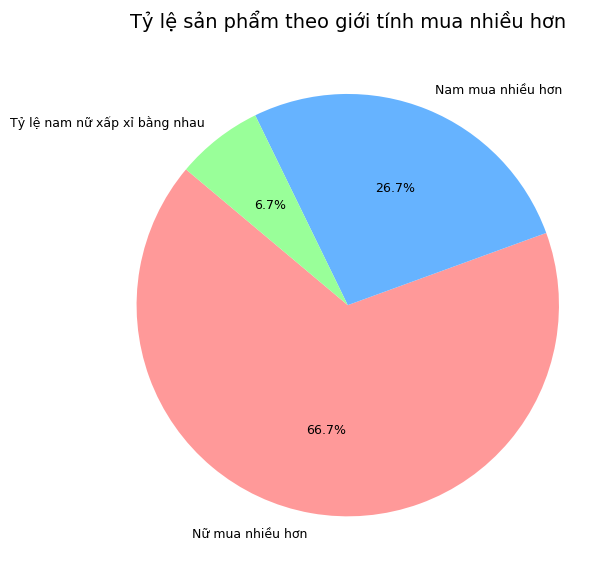

In [27]:
# Danh sách nhãn cố định theo thứ tự
all_labels = ['Nữ mua nhiều hơn', 'Nam mua nhiều hơn', 'Tỷ lệ nam nữ xấp xỉ bằng nhau']
sizes = [label_counts.get(label, 0) for label in all_labels]  # Lấy số lượng theo đúng thứ tự

# Màu sắc tương ứng
colors = ['#FF9999', '#66B3FF', '#99FF99']

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=all_labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 9})
plt.title('Tỷ lệ sản phẩm theo giới tính mua nhiều hơn', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

- Các sản phẩm nữ mua nhiều nhất(100%): Mì chính, Trứng gà, Bánh quy, Thịt bò.
- Các sản phẩm nam mua nhiều nhất(100%): Mì ăn liền, Hạt tiêu đen, Đường trắng, Muối i-ốt.
- Các sản phẩm nam nữ mua xấp xỉ nhau(<10%): Cà phê lon.

> Tệp khách hàng phổ biến của cửa hàng nằm trong độ tuổi bao nhiêu?  

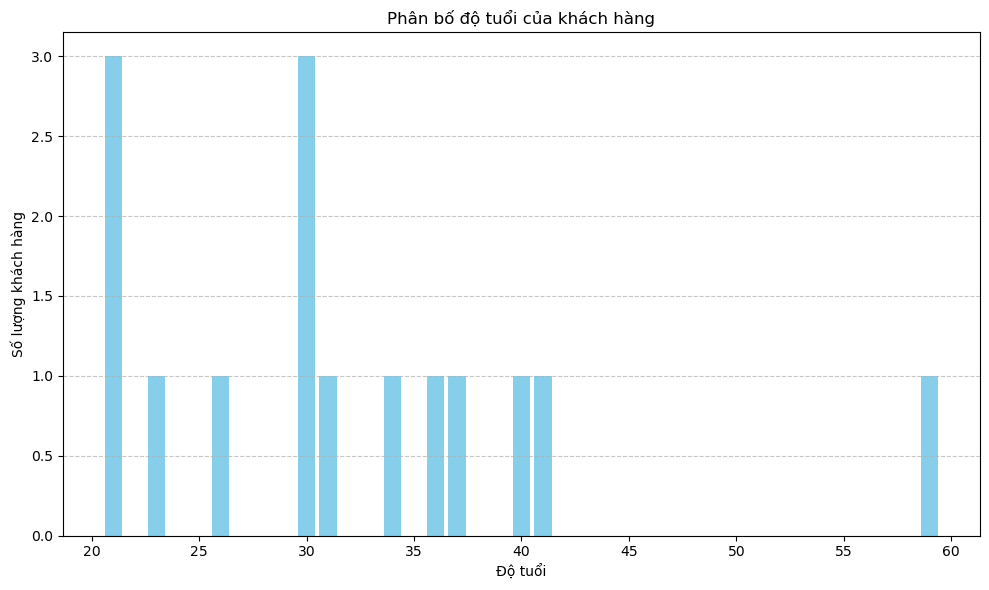

In [28]:
# Tính tuổi theo ngày hiện tại, phân nhóm độ tuổi, đếm số khách hàng.
cursor.execute("""
SELECT 
    CAST((julianday('now') - julianday(birth_date)) / 365 AS INTEGER) AS age,
    COUNT(*) AS customer_count
FROM customers
GROUP BY age
ORDER BY age
""")
data = cursor.fetchall()
ages = [row[0] for row in data]
counts = [row[1] for row in data]

plt.figure(figsize=(10,6))
plt.bar(ages, counts, color='skyblue')
plt.xlabel("Độ tuổi")
plt.ylabel("Số lượng khách hàng")
plt.title("Phân bố độ tuổi của khách hàng")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Tệp khách hàng phổ biến của cửa hàng nằm trong độ tuổi từ 18 đến 32 tuổi.
    - Cao nhất là nhóm khách hàng 28-29 tuổi.

> Thời gian trung bình mà khách hàng đó quay lại cửa hàng là bao lâu (tính theo 
ngày)? 

In [29]:
# Tính khoảng cách trung bình giữa các đơn hàng của cùng khách hàng.
query2 = """
WITH order_dates AS (
    SELECT
        customer_id,
        order_date,
        LEAD(order_date) OVER (PARTITION BY customer_id ORDER BY order_date) AS next_order_date
    FROM orders
),
order_intervals AS (
    SELECT
        customer_id,
        julianday(next_order_date) - julianday(order_date) AS days_between
    FROM order_dates
    WHERE next_order_date IS NOT NULL
),
avg_by_customer AS (
    SELECT
        customer_id,
        AVG(days_between) AS avg_days_between_orders
    FROM order_intervals
    GROUP BY customer_id
)
SELECT
    ROUND(AVG(avg_days_between_orders), 2) AS avg_return_days_overall
FROM avg_by_customer;

"""
cursor.execute(query2)
result2 = cursor.fetchone()[0]
print(f"Khoảng cách trung bình giữa các đơn hàng của mỗi khách hàng là {result2:.2f} ngày.")

Khoảng cách trung bình giữa các đơn hàng của mỗi khách hàng là 23.17 ngày.


- Tần suất mua hàng trung bình của khách hàng là mỗi nửa tháng. 

### d. Từ các bảng dữ liệu trên, hãy tạo một bộ dữ liệu mới customer_details chứa các thông tin sau: 
- Các thông tin liên quan đến khách hàng. 
- Thông tin về ngày mua của khách hàng theo tuần và tháng. 
- Số lượng trung bình các sản phẩm khác nhau mà khách hàng đã từng mua. 
- Số tiền trung bình mà khách hàng đó cần phải trả trong một lần mua hàng. 
- Số ngày trung bình giữa các lần mua hàng của khách hàng đó. 

In [30]:
cursor.execute('''
CREATE VIEW customer_details AS
WITH order_summary AS (
    SELECT
        oi.order_id,
        o2.customer_id,
        COUNT(DISTINCT oi.product_id) AS product_count,
        SUM(oi.quantity * p.price) AS total_amount,
        LAG(julianday(o2.order_date)) OVER (PARTITION BY o2.customer_id ORDER BY o2.order_date) AS prev_order_date,
        julianday(o2.order_date) AS current_order_date
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN orders o2 ON oi.order_id = o2.order_id
    GROUP BY oi.order_id, o2.customer_id
),
order_intervals AS (
    SELECT
        order_id,
        customer_id,
        product_count,
        total_amount,
        current_order_date - prev_order_date AS days_between_orders
    FROM order_summary
    WHERE prev_order_date IS NOT NULL
),
purchase_dates AS (
    SELECT
        customer_id,
        MIN(strftime('%Y-%W', order_date)) AS first_purchase_week,
        MAX(strftime('%Y-%W', order_date)) AS last_purchase_week,
        MIN(strftime('%Y-%m', order_date)) AS first_purchase_month,
        MAX(strftime('%Y-%m', order_date)) AS last_purchase_month
    FROM orders
    GROUP BY customer_id
)
SELECT
    c.customer_id,
    c.gender,
    c.birth_date,
    c.signup_date,

    pd.first_purchase_week,
    pd.last_purchase_week,
    pd.first_purchase_month,
    pd.last_purchase_month,

    ROUND(AVG(oi.product_count), 2) AS avg_unique_products_per_order,
    ROUND(AVG(oi.total_amount), 0) AS avg_amount_per_order,
    ROUND(AVG(oi.days_between_orders), 1) AS avg_days_between_orders

FROM customers c
LEFT JOIN purchase_dates pd ON c.customer_id = pd.customer_id
LEFT JOIN order_intervals oi ON c.customer_id = oi.customer_id

GROUP BY c.customer_id, c.gender, c.birth_date, c.signup_date;
''')
conn.commit()

In [31]:
df_customer_details = pd.read_sql_query("SELECT * FROM customer_details", conn)
print(df_customer_details)

   customer_id gender                  birth_date signup_date  \
0        C1503      F  2004-02-09 15:49:40.571879  2025-04-26   
1        C1942      F  2001-12-12 15:49:40.571879  2025-03-03   
2        C2084      F  1987-07-03 15:49:40.571879  2025-04-26   
3        C2797      F  1995-05-03 15:49:40.571879  2025-04-02   
4        C3475      F  1965-10-13 15:49:40.571879  2025-04-26   
5        C5032      M  1988-10-04 15:49:40.571879  2025-02-21   
6        C5067      M  1984-07-31 15:49:40.571879  2025-01-18   
7        C5520      M  2004-01-27 15:49:40.571879  2025-05-11   
8        C5574      M  1998-10-21 15:49:40.571879  2025-03-29   
9        C6528      F  1984-04-05 15:49:40.571879  2025-01-26   
10       C6710      F  1994-05-12 15:49:40.571879  2025-02-22   
11       C7687      F  1995-02-02 15:49:40.571879  2025-05-04   
12       C7955      M  2003-06-28 15:49:40.571879  2025-05-21   
13       C8692      M  1991-03-08 15:49:40.571879  2025-04-06   
14       C9923      M  19

- Các thông tin liên quan đến khách hàng: customer_id, gender, birth_date, signup_date.
- Các biến mới:
    - *first_purchase_week*:              Tuần đầu tiên khách hàng thực hiện đơn hàng (theo format YYYY-WW).
    - *last_purchase_week*:               Tuần cuối cùng khách hàng mua hàng.
    - *first_purchase_month*:             Tháng đầu tiên khách hàng mua hàng (YYYY-MM).
    - *last_purchase_month*:              Tháng cuối cùng khách hàng mua hàng.
    - *avg_unique_products_per_order*:    Trung bình số loại sản phẩm khác nhau trong mỗi đơn hàng.
    - *avg_amount_per_order*:             Số tiền trung bình mà khách hàng chi cho mỗi đơn hàng.
    - *avg_days_between_orders*:          Số ngày trung bình giữa các lần mua hàng của khách hàng đó.

### e. Từ bảng customer_details trên, hãy tính: 
> Trung bình có bao nhiêu tài khoản được đăng ký trong một ngày? 


In [32]:
query3 = """
SELECT
    ROUND(COUNT(*) * 1.0 / NULLIF(julianday(MAX(signup_date)) - julianday(MIN(signup_date)), 0), 2) AS avg_accounts_per_day
FROM customers;
"""

avg_accounts = pd.read_sql_query(query3, conn).iloc[0, 0]
print(f"Trung bình có {avg_accounts} tài khoản được đăng ký mỗi ngày.")

Trung bình có 0.12 tài khoản được đăng ký mỗi ngày.


- Lượng khách hàng có thể truy cập có hạn(15 người) so với thời gian vài tháng nên số lượng tài khoản đăng ký nhận được mỗi ngày thấp(0.13tk/ngày).

> Doanh thu trung bình trong mỗi tháng cửa hàng thu được là bao nhiêu?  


In [33]:
query4 = """
SELECT
    ROUND(AVG(monthly_revenue), 0) AS avg_monthly_revenue
FROM (
    SELECT
        strftime('%Y-%m', o.order_date) AS month,
        SUM(oi.quantity * p.price) AS monthly_revenue
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    GROUP BY strftime('%Y-%m', o.order_date)
);
"""
avg_revenue = pd.read_sql_query(query4, conn).iloc[0, 0]
print(f" Doanh thu trung bình mỗi tháng là {avg_revenue:,.0f} VNĐ.")

 Doanh thu trung bình mỗi tháng là 375,600 VNĐ.


>Sản phẩm nào được mua nhiều nhất và ít nhất?

In [ ]:
# Sản phẩm bán nhiều nhất
query_max = """
SELECT
    p.name,
    SUM(oi.quantity) AS total_quantity
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_id, p.name
ORDER BY total_quantity DESC
LIMIT 1;
"""
most_bought = pd.read_sql_query(query_max, conn)
print(f" Sản phẩm bán chạy nhất: {most_bought['name'][0]} ({most_bought['total_quantity'][0]} lượt mua)")

# Sản phẩm bán ít nhất
query_min = """
SELECT
    p.name,
    SUM(oi.quantity) AS total_quantity
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_id, p.name
ORDER BY total_quantity ASC
LIMIT 1;
"""
least_bought = pd.read_sql_query(query_min, conn)
print(f" Sản phẩm ít được mua nhất: {least_bought['name'][0]} ({least_bought['total_quantity'][0]} lượt mua)")

 Sản phẩm bán chạy nhất: Nước táo ép (12 lượt mua)
 Sản phẩm ít được mua nhất: Sữa tươi (1 lượt mua)


: 